## Forecasting for Monitor

This notebook walks through building charts used in the Monitor application.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

In [1]:
import os
import logging
import pandas as pd
from pandas import Grouper
from pygam import LinearGAM, s, f
import matplotlib
import matplotlib.pyplot as plt
import pytz
import datetime
import numpy as np

from sklearn.metrics import r2_score #, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor

try:
    from django.db import models
    from traffic_monitor.models.model_logentry import LogEntry
    from traffic_monitor.models.model_monitor import Monitor
    

except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper, ColorBar, FixedTicker, NumeralTickFormatter

from bokeh.models import HoverTool, WheelZoomTool, ResetTool
from bokeh.models import Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import brewer, RdYlGn11
from bokeh.embed import components
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, HTMLTemplateFormatter, TableColumn, DataTable, HoverTool, \
    DatetimeTickFormatter, Line, FactorRange
from bokeh.plotting import figure
from django.http import JsonResponse
output_notebook()

Loading BokehJS ...

In [2]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

In [3]:
# categories = ['truck', 'bus', 'car', 'motorcycle', 'person']
# def get_rs(monitor_name='MyMonitor', categories=['truck', 'bus', 'car', 'motorcycle', 'person']):
#     return LogEntry.objects.filter(monitor_id=monitor_name, class_name__in=categories).all().values()

In [4]:
# def get_rs(monitor_name, categories=None, from_date: str = None):
#     # date should be in ISO format YYYY-MM-DDTHH:MM
#     # expected time is in monitor's time zone
#     _filter_args = {'monitor_id': monitor_name}
#     if categories is not None:
#         _filter_args.update({'class_name__in': categories})
#     if from_date is not None:
#         time_zone = Monitor.objects.get(pk=monitor_name).feed.time_zone
#         from_date = datetime.datetime.fromisoformat(from_date).replace(tzinfo=pytz.timezone(time_zone)).astimezone(pytz.UTC)
#         _filter_args.update({'time_stamp__gte': from_date})
#     return LogEntry.objects.filter(**_filter_args).all().values()

In [5]:
# def set_interval(_df: pd.DataFrame, interval: int):
#     """ Takes raw DF from Django call the LogEntry.objects.all().values() """
#     """ 'interval' must divide hour into equal portions; 60, 30, 15, 10, 6, 4, 3, 2, 1"""
#     if 60%interval !=0:
#         logger.error("Interval must be evenly divided into 60: (60, 30, 15, 10, 6, 4, 3, 2 or 1)")
#     monitor_name:str = _df.monitor_id.unique()[0]
#     time_zone = Monitor.objects.get(pk=monitor_name).feed.time_zone
    
#     _df.rename(columns={'count': 'rate'}, inplace=True)
    
#     # convert time to video local timezone and then remove timezone awareness
#     _df['time_stamp'] = _df['time_stamp'].dt.tz_convert(pytz.timezone(time_zone)).dt.tz_localize(None)
    
#     # make columns categorical and remove multi_index
#     _df = _df.pivot_table(index=['time_stamp'], columns='class_name', values='rate', fill_value=0)
    
#     _df.columns = _df.columns.get_level_values(0).values
#     _df['year'] = pd.Series(_df.index).apply(lambda s: s.year).values
#     _df['month'] = pd.Series(_df.index).apply(lambda s: s.month).values
#     _df['day'] = pd.Series(_df.index).apply(lambda s: s.day).values
#     _df['hour'] = pd.Series(_df.index).apply(lambda s: s.hour).values
#     _df['interval'] = pd.Series(_df.index).apply(lambda s : int(s.minute / interval) * interval).values
    
#     _df = _df.groupby(['year','month','day','hour', 'interval']).mean()
#     # reconfigure index to a timestamp
#     _df.set_index(pd.Series(list(_df.index)).apply(lambda s: datetime.datetime(*s)), inplace=True)

#     # complete interval sequence
#     start_time = _df.index.min()
#     end_time = _df.index.max()
#     new_interval = []
#     t = start_time
#     while t <= end_time:
#         new_interval.append(t)
#         t += pd.Timedelta(f"{interval} minutes")
        
#     _df = pd.DataFrame(index=new_interval).join(_df, how='outer')
    
#     # fill missing time intervals for forward filling the first half and backfilling the second half
#     while _df.isna().any().any():
#         _df.fillna(method='ffill', limit=1, inplace=True)
#         _df.fillna(method='bfill', limit=1, inplace=True)
    
#     _df = _df.melt(ignore_index=False, var_name='class_name', value_name='rate')
    
#     return _df.reset_index().rename(columns={'index': 'time_stamp'})


In [6]:
# def add_category_codes(_df, column_to_cat, new_col_name):
#     # Use numerical category codes
#     idx = int(np.where(_df.columns == column_to_cat)[0][0])
#     _df[column_to_cat] = pd.Categorical(_df[column_to_cat])
#     _df.insert(idx+1, new_col_name, _df[column_to_cat].cat.codes)
    
#     return _df

In [7]:
# def get_cat_map(_df, string_column, code_column) -> dict:
#     _cat_map_name_to_code = _df[[string_column, code_column]].set_index(string_column).drop_duplicates().to_dict()[code_column]
#     _cat_map_code_to_name = _df[[string_column, code_column]].set_index(code_column).drop_duplicates().to_dict()[string_column]
#     cat_map = {**_cat_map_code_to_name, **_cat_map_name_to_code}
#     cat_map.update({'classes': list(_cat_map_name_to_code.keys())})
#     cat_map.update({'codes': list(_cat_map_code_to_name.keys())})
    
#     return cat_map


In [8]:
# def extend_time_features(_df: pd.DataFrame):
#     """ add time characteristics that allow grouping """
#     _df['year'] = pd.Series(_df.time_stamp).apply(lambda s: s.year).values
#     _df['month'] = pd.Series(_df.time_stamp).apply(lambda s: s.month).values
#     _df['day'] = pd.Series(_df.time_stamp).apply(lambda s: s.day).values
#     _df['weekday'] = pd.Series(_df.time_stamp).apply(lambda s: s.weekday()).values
#     _df['hour'] = pd.Series(_df.time_stamp).apply(lambda s: s.hour).values
#     _df['minute'] = pd.Series(_df.time_stamp).apply(lambda s: s.minute).values
#     _df['day_minute'] = pd.Series(_df.time_stamp).apply(lambda s :(s.hour * 60 + s.minute)).values
#     _df['week_minute'] = pd.Series(_df.time_stamp).apply(lambda s :(s.weekday() * 24*60) + (s.hour * 60) + s.minute).values
    
#     return _df

In [9]:
# def add_history_columns(_df, value_column='rate', category_column='class_name', n_intervals=24*4):
#     # value_column is the column to get the history for
#     # n_intervals are the number of history columns to add
#     categories = _df[category_column].unique()
#     for i in range(1,n_intervals+1):
#         for c in categories:
#             idx = _df.loc[_df[category_column] == c].index
#             _df.loc[idx, f'-{i}'] = _df[_df[category_column] == c][value_column].shift(i)
#     _df.dropna(inplace=True)
#     return _df.reset_index(drop=True)

In [10]:
# def add_future_columns(_df, value_column='rate', category_column='class_name', n_intervals=24*4):
#     # value_column is the column to get the history for
#     # n_intervals are the number of history columns to add
#     categories = _df[category_column].unique()
#     for i in range(1,n_intervals+1):
#         for c in categories:
#             idx = _df.loc[_df[category_column] == c].index
#             _df.loc[idx, f'+{i}'] = _df[_df[category_column] == c][value_column].shift(-i)
#     _df.dropna(inplace=True)
#     return _df.reset_index(drop=True)

In [11]:
# # split into train and test sets
# def get_train_test_split(_df, hours_in_test=24, categories=None):
    
#     if categories is not None:
#         _df = _df[_df.class_name.isin(categories)]

#     split_time = _df.time_stamp.max() - pd.Timedelta(f"{hours_in_test+1} hours")
#     train = _df[_df.time_stamp < split_time]
#     test = _df[_df.time_stamp >= split_time]

# #     X_train = train.drop(columns=['class_name', 'rate'] + [c for c in train.columns if c.startswith('+')]).reset_index(drop=True)
# #     X_test = test.drop(columns=['class_name', 'rate'] + [c for c in train.columns if c.startswith('+')]).reset_index(drop=True)
    
# #     future_columns = [f"+{c}" for c in range(1,y_intervals) if f"+{c}" in train.columns]
# #     y_train = np.squeeze(train[['rate'] + future_columns]).reset_index(drop=True)
# #     y_test = np.squeeze(test[['rate'] + future_columns]).reset_index(drop=True)

#     return train, test

In [43]:
Monitor.objects.get(pk='MyMonitor').log_objects

['bus', 'car', 'truck', 'motorcycle', 'person']

In [12]:
class ModelConfig:
    # Use Pandas Timestamp for datetime to ensure DST conversions are consistent
    def __init__(self, monitor_name:str, interval:int, hours_in_training:int, 
                 hours_in_prediction:int, predictor_columns:list=['class_code'], response_columns:list=['rate'],
                 source_data_from_date:str=None):
        self.monitor_name: str = monitor_name
        self.time_zone = Monitor.objects.get(pk=self.monitor_name).feed.time_zone
        self.interval:int = interval
        self.hours_in_training:int = hours_in_training
        self.hours_in_prediction:int = hours_in_prediction
        self.predictor_columns = None
        self.response_columns = response_columns
        self.from_date_utc = None if source_data_from_date is None else pd.Timestamp(source_data_from_date, tz=self.time_zone).tz_convert(pytz.UTC)
        self.categories:list = Monitor.objects.get(pk=self.monitor_name).log_objects
        self.full_df:pd.DataFrame = None
        self.train_df:pd.DataFrame = None
        self.test_df:pd.DataFrame = None
        self.cat_to_code_map: dict = {c: i for i, c in enumerate(self.categories)}
        self.code_to_cat_map: dict = {v: k for k, v in self.cat_to_code_map.items()}
        
        self._set_dates()
        self._set_full_df()
        self._set_train_test_split()
        self.set_predictor_columns(predictor_columns)
        
    def get_code(self, category_name: str):
        return self.cat_to_code_map.get(category_name)
    
    def get_category(self, category_code: int):
        return self.code_to_cat_map.get(category_code)
    
    def _set_dates(self):
        if self.from_date_utc is None:
            self.from_date_utc = pd.Timestamp(LogEntry.objects.filter(monitor=self.monitor_name).earliest('time_stamp').time_stamp)
            
    def _get_logdata_df(self, from_date=None):
        # times returned are in UTC
        _filter_args = {'monitor_id': self.monitor_name}
        _filter_args.update({'class_name__in': self.categories})
        if from_date is None:
            _filter_args.update({'time_stamp__gte': self.from_date_utc})
        else:
            _filter_args.update({'time_stamp__gte': from_date})
        _df = pd.DataFrame(LogEntry.objects.filter(**_filter_args).all().values())
        
        if len(_df) == 0:
            raise Exception(f"No records returned: monitor:{self.monitor_name} from_date_utc:{self.from_date_utc} from_date:{from_date} categories:{self.categories}")
        
        # convert time to monitor's timezone
        _df['time_stamp'] = _df['time_stamp'].dt.tz_convert(pytz.timezone(self.time_zone))
        return _df
        
    def _set_train_test_split(self):    
        split_time = self.full_df.time_stamp.max() - pd.Timedelta(f"{self.hours_in_prediction+1} hours")
        self.train_df = self.full_df[self.full_df.time_stamp < split_time]
        self.test_df = self.full_df[self.full_df.time_stamp >= split_time]
        
    def get_train_test_split(self):
        if self.train_df is None or self.test_df is None:
            self._set_train_test_split()
            
        _tr_x = self.train_df[self.predictor_columns].reset_index(drop=True)
        _te_x = self.test_df[self.predictor_columns].reset_index(drop=True)    
        _tr_y = self.train_df[self.response_columns].reset_index(drop=True).to_numpy()
        _te_y = self.test_df[self.response_columns].reset_index(drop=True).to_numpy()
        
        # reshape single y columns
        if len(_tr_y.shape) > 1 and _tr_y.shape[1]==1:
            _tr_y = _tr_y.reshape(-1)
        if len(_te_y.shape) > 1 and _te_y.shape[1]==1:
            _te_y = _te_y.reshape(-1)
            
        return _tr_x, _tr_y, _te_x, _te_y
        
    def set_predictor_columns(self, string_cols: list):
        """ Adds the history columns to a provided list of columns """
        self.predictor_columns = string_cols + [c for c in self.full_df.columns if c.startswith('-')][::-1]
    
    def _set_interval(self, _df: pd.DataFrame, interval: int):
        """ Takes raw DF from Django call the LogEntry.objects.all().values() """
        """ 'interval' must divide hour into equal portions; 60, 30, 15, 10, 6, 4, 3, 2, 1"""
        if 60%interval !=0:
            logger.error("Interval must be evenly divided into 60: (60, 30, 15, 10, 6, 4, 3, 2 or 1)")

        _df.rename(columns={'count': 'rate'}, inplace=True)

        # make columns categorical and remove multi_index
        _df = _df.pivot_table(index=['time_stamp'], columns='class_name', values='rate', fill_value=0)

        _df.columns = _df.columns.get_level_values(0).values
        _df['year'] = pd.Series(_df.index).apply(lambda s: s.year).values
        _df['month'] = pd.Series(_df.index).apply(lambda s: s.month).values
        _df['day'] = pd.Series(_df.index).apply(lambda s: s.day).values
        _df['hour'] = pd.Series(_df.index).apply(lambda s: s.hour).values
        _df['interval'] = pd.Series(_df.index).apply(lambda s : int(s.minute / interval) * interval).values

        _df = _df.groupby(['year','month','day','hour', 'interval']).mean()
        # reconfigure index to a timestamp
        _df.set_index(pd.Series(list(_df.index)).apply(lambda s: datetime.datetime(*s)), inplace=True)

        # complete interval sequence
        start_time = _df.index.min()
        end_time = _df.index.max()
        new_interval = []
        t = start_time
        while t <= end_time:
            new_interval.append(t)
            t += pd.Timedelta(f"{interval} minutes")

        _df = pd.DataFrame(index=new_interval).join(_df, how='outer')

        # fill missing time intervals for forward filling the first half and backfilling the second half
        while _df.isna().any().any():
            _df.fillna(method='ffill', limit=1, inplace=True)
            _df.fillna(method='bfill', limit=1, inplace=True)

        _df = _df.melt(ignore_index=False, var_name='class_name', value_name='rate')

        return _df.reset_index().rename(columns={'index': 'time_stamp'})

    
    def _add_categorical_column(self, _df, cat_col_name, code_col_name):
        idx = int(np.where(_df.columns == cat_col_name)[0][0])
        _df.insert(idx+1, code_col_name, _df[cat_col_name].apply(lambda s: self.get_code(s)))
        return _df
    
    def _add_time_features(self, _df: pd.DataFrame):
        """ add time characteristics that allow grouping """
        _df['year'] = pd.Series(_df.time_stamp).apply(lambda s: s.year).values
        _df['month'] = pd.Series(_df.time_stamp).apply(lambda s: s.month).values
        _df['day'] = pd.Series(_df.time_stamp).apply(lambda s: s.day).values
        _df['weekday'] = pd.Series(_df.time_stamp).apply(lambda s: s.weekday()).values
        _df['hour'] = pd.Series(_df.time_stamp).apply(lambda s: s.hour).values
        _df['minute'] = pd.Series(_df.time_stamp).apply(lambda s: s.minute).values
        _df['day_minute'] = pd.Series(_df.time_stamp).apply(lambda s :(s.hour * 60 + s.minute)).values
        _df['week_minute'] = pd.Series(_df.time_stamp).apply(lambda s :(s.weekday() * 24*60) + (s.hour * 60) + s.minute).values

        return _df
    
    def _add_history_columns(self, _df):
        # history columns are added to training datasets
        # value_column is the column to get the history for
        # n_intervals are the number of history columns to add
        categories = _df['class_name'].unique()
        n_intervals = self.hours_in_training * int(60/self.interval)
        for i in range(1, n_intervals+1):
            for c in categories:
                idx = _df.loc[_df['class_name'] == c].index
                _df.loc[idx, f'-{i}'] = _df[_df['class_name'] == c]['rate'].shift(i)
        _df.dropna(inplace=True)
        return _df.reset_index(drop=True)
    
    def _set_full_df(self):
        _df = self._get_logdata_df()
        _df = self._set_interval(_df, interval=self.interval)
        _df = self._add_categorical_column(_df, 'class_name', 'class_code')
        _df = self._add_time_features(_df)
        _df = self._add_history_columns(_df)
        
        self.full_df = _df
        
    def get_seed_observation(self, on_date='latest'):
        # get the most recent observation or the first observation on a provided date
        # provided as from_date (is isoformat YYYY-MM_DDTHH:MM)
        # on_date is expected to be in the monitor's timezone
        if on_date == 'latest' or on_date is None:
            on_date = self.full_df.time_stamp.max()
        else:
            on_date = pd.Timestamp(on_date)
            on_date = self.full_df.time_stamp[self.full_df.time_stamp >= on_date].min()
        
        _df = self.full_df[self.full_df.time_stamp == on_date]
        time_zero = _df['rate'].values
        
        # only keep the class_code and time columns
        _df = _df.reset_index(drop=True)[self.predictor_columns]
        _df["0"] = time_zero
        
        if len(_df) == 0:
            raise Exception(f"Unable to get forecasting seed: monitor:{self.monitor_name}, interval:{self.interval}, pred_hours:{predictor_hours}, on_date:{on_date}, categories:{self.categories}")

        return _df, on_date


In [13]:
model_config = ModelDataConfig(monitor_name='MyMonitor',
                                 interval=15,
                                 hours_in_training=24,
                                 hours_in_prediction=24*7,
                                 source_data_from_date="2020-09-27",
                                 categories=['truck', 'bus', 'car', 'motorcycle', 'person'])

<h1>Review Dataset</h1>
Visualize the dataset that we will be working with

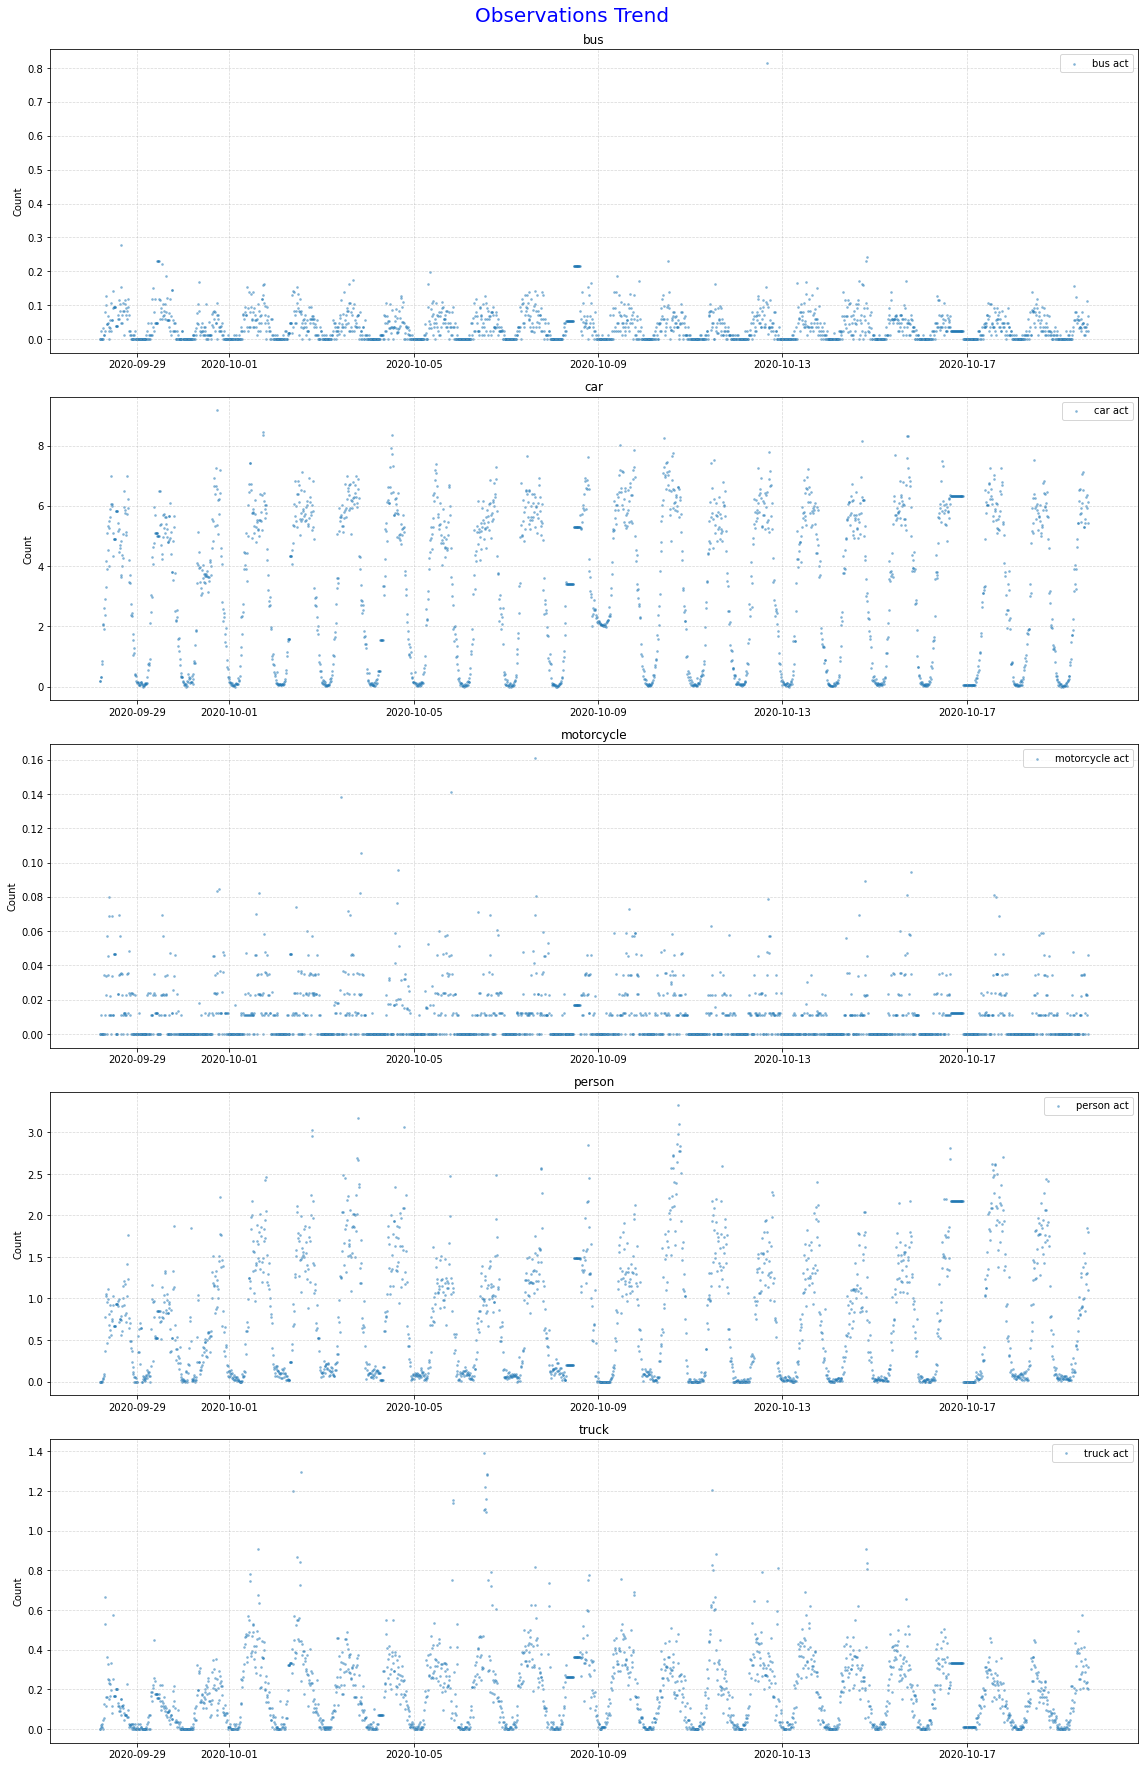

In [14]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Observations Trend\n", fontsize=20, c='b')

plot_df = model_config.full_df

for i, c in enumerate(plot_df.class_name.unique()):
    _p = plot_df[plot_df.class_name == c]
    subplot[i].scatter(_p.time_stamp, _p.rate, alpha=.4, label=f"{c} act", s=3)

    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [15]:
print(f"{'Object':15}  {'Count':>10}")
for c in model_config.full_df.class_name.unique():
    print(f"{c:15}  {(model_config.full_df[model_config.full_df.class_name == c]['rate'] != 0).sum():>10}")

Object                Count
bus                    1375
car                    2049
motorcycle              914
person                 1931
truck                  1794


<h1>Predict Based on Weekday Average</h1>
Predict based on each day's average.

In [16]:
weekdayavg_train_df = model_config.train_df[['weekday', 'class_name', 'rate']].groupby(['weekday', 'class_name']).agg([np.mean, np.std])
weekdayavg_test_df = model_config.test_df[['weekday', 'class_name', 'rate']].groupby(['weekday', 'class_name']).agg([np.mean, np.std])

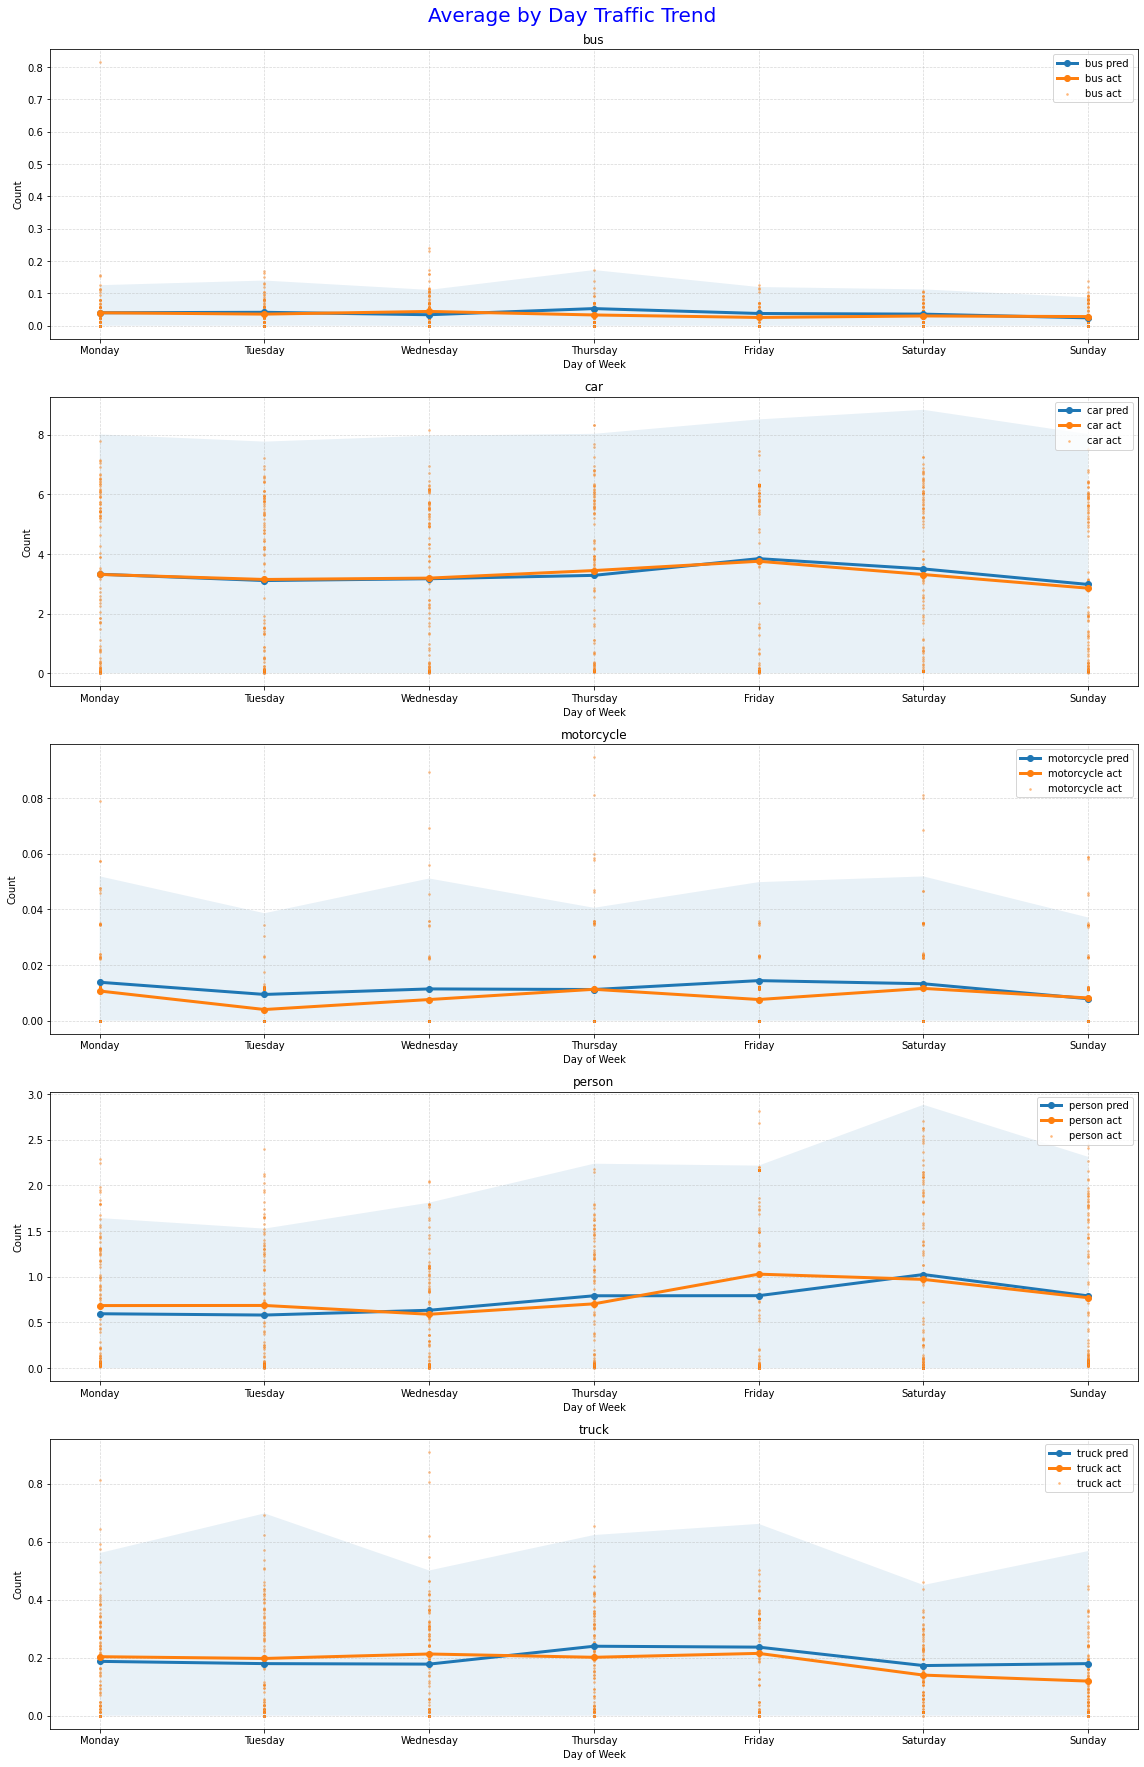

In [17]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Day Traffic Trend\n", fontsize=20, c='b')

_train_df = weekdayavg_train_df
_test_df = weekdayavg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(model_config.test_df[model_config.test_df.class_name == c].weekday, model_config.test_df[model_config.test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Day of Week")
    tick_locations = range(0,7)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

Measure accuracy

In [18]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(weekdayavg_test_df.index.get_level_values(1).unique()):
    true = weekdayavg_test_df[weekdayavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = weekdayavg_train_df[weekdayavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus           -1.75
car           0.813
motorcycle   -1.359
person        0.448
truck         0.038


<h1>Predict by Hour of Day</h1>
Predict based on the time of day.

In [19]:
houravg_train_df = model_config.train_df[['hour', 'class_name', 'rate']].groupby(['hour', 'class_name']).agg([np.mean, np.std])
houravg_test_df = model_config.test_df[['hour', 'class_name', 'rate']].groupby(['hour', 'class_name']).agg([np.mean, np.std])


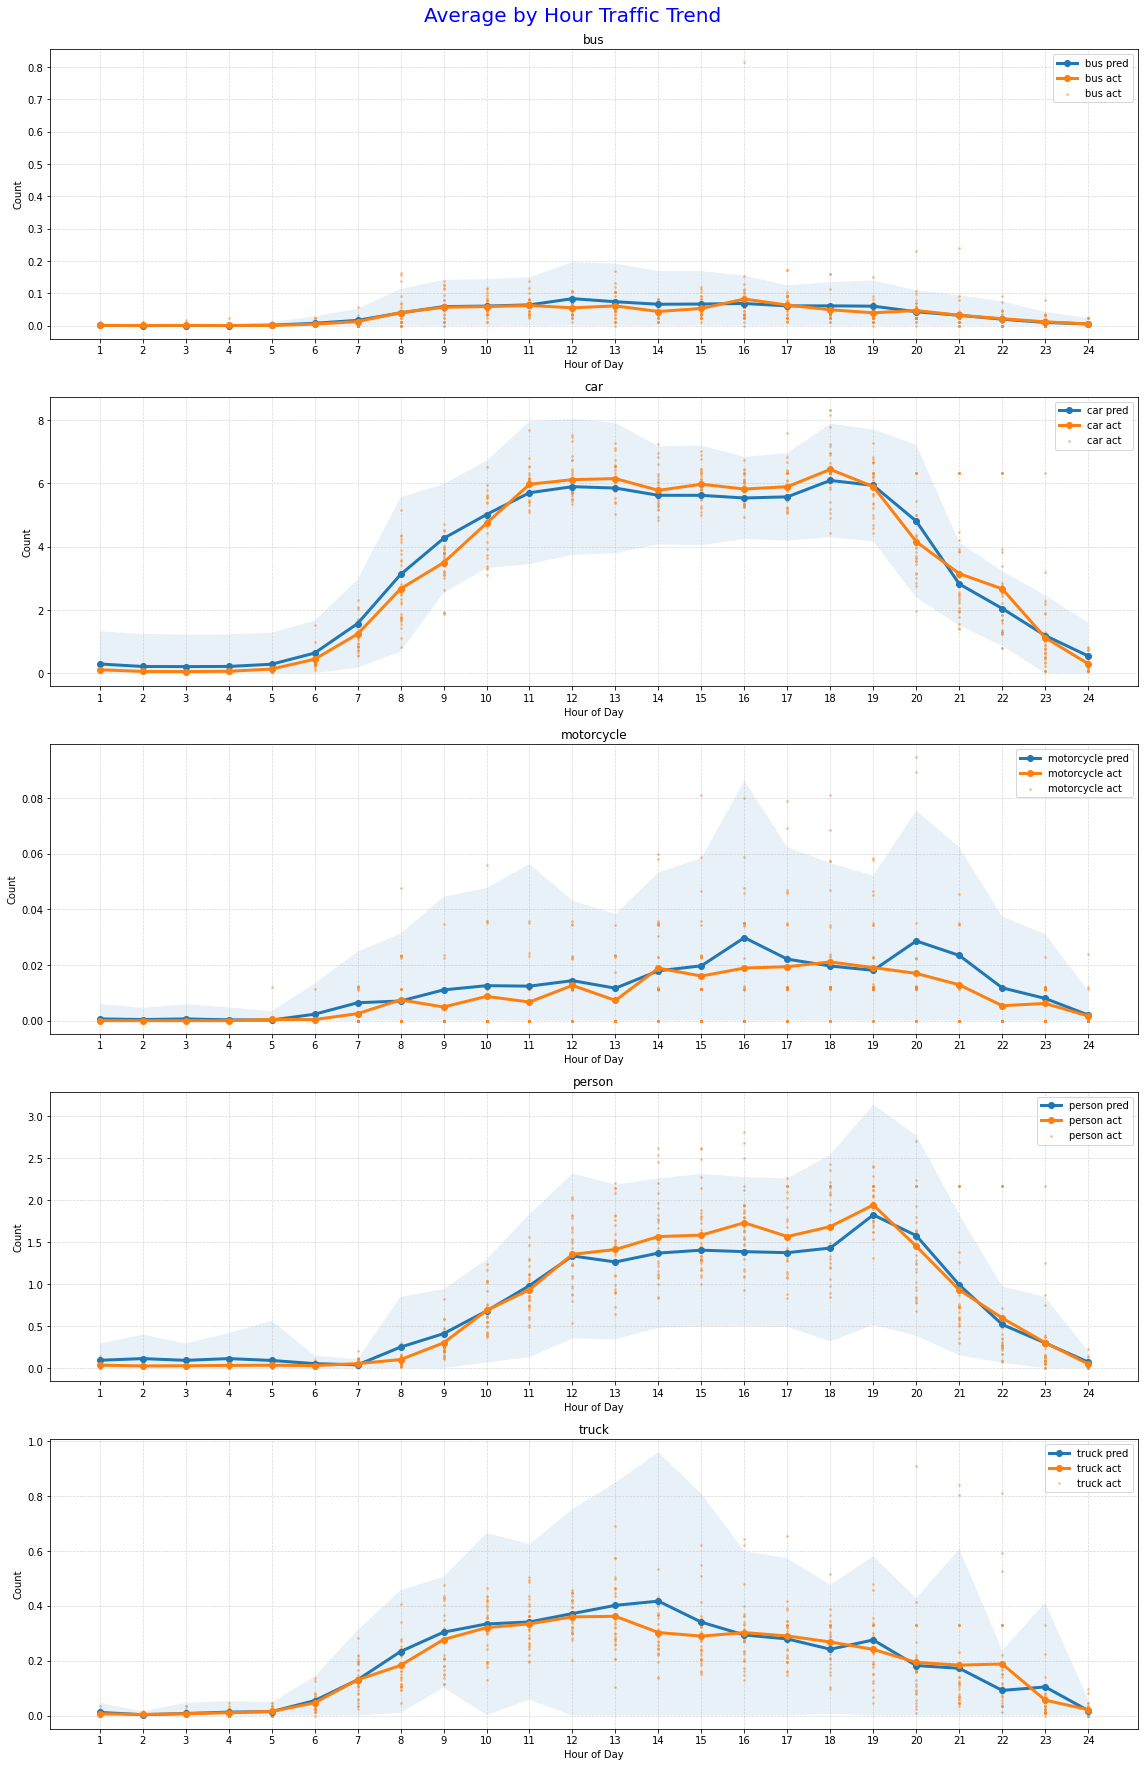

In [20]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Hour Traffic Trend\n", fontsize=20, c='b')

_train_df = houravg_train_df
_test_df = houravg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(model_config.test_df[model_config.test_df.class_name == c].hour, model_config.test_df[model_config.test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("Hour of Day")
    tick_locations = range(0,24)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(range(1,25))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [21]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(houravg_test_df.index.get_level_values(1).unique()):
    true = houravg_test_df[houravg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = houravg_train_df[houravg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus           0.841
car           0.981
motorcycle    0.568
person        0.964
truck         0.911


<h1>Predict by X minute Interval of Day</h1>
Predict based on the time of day.

In [22]:
intavg_train_df = model_config.train_df[['day_minute', 'class_name', 'rate']].groupby(['day_minute', 'class_name']).agg([np.mean, np.std])
intavg_test_df = model_config.test_df[['day_minute', 'class_name', 'rate']].groupby(['day_minute', 'class_name']).agg([np.mean, np.std])


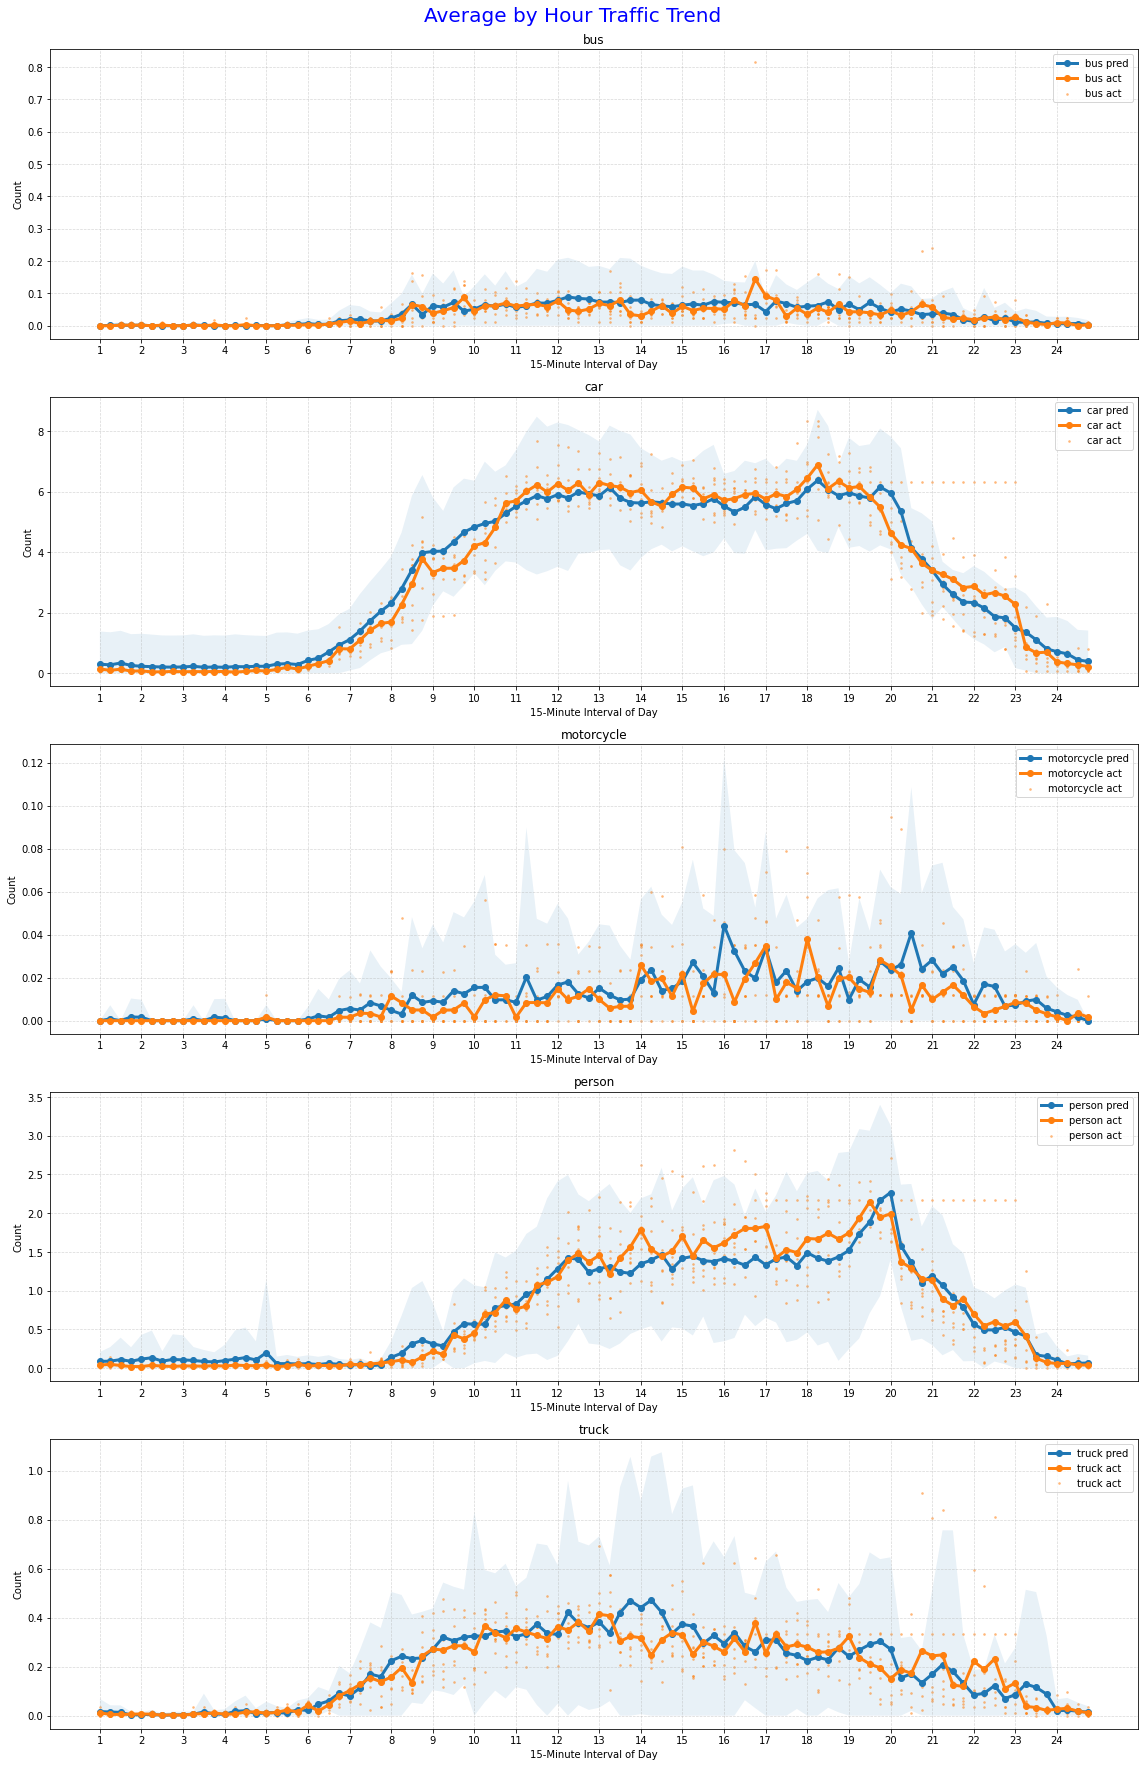

In [23]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Hour Traffic Trend\n", fontsize=20, c='b')

_train_df = intavg_train_df
_test_df = intavg_test_df

for i, c in enumerate(_train_df.index.get_level_values(1).unique()):
    _pr_df = _train_df[_train_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", marker='o', lw=3)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(model_config.test_df[model_config.test_df.class_name == c].day_minute, model_config.test_df[model_config.test_df.class_name == c].rate, alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", marker='o', lw=3)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("15-Minute Interval of Day")
    tick_locations = range(0,60*24, 60)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(range(1,25))
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [24]:
print(f"{'Class':10} {'r2 score':>8}")
for i, c in enumerate(intavg_test_df.index.get_level_values(1).unique()):
    true = intavg_test_df[intavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = intavg_train_df[intavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

Class      r2 score
bus           0.596
car           0.973
motorcycle    0.183
person        0.946
truck         0.797


<h1>Predict by Time of Day and Day of Week</h1>
Use the time of the day and the day of the week.

In [25]:
weekminavg_train_df = model_config.train_df[['week_minute', 'class_name', 'rate']].groupby(['week_minute', 'class_name']).agg([np.mean, np.std])
weekminavg_test_df = model_config.test_df[['week_minute', 'class_name', 'rate']].groupby(['week_minute', 'class_name']).agg([np.mean, np.std])


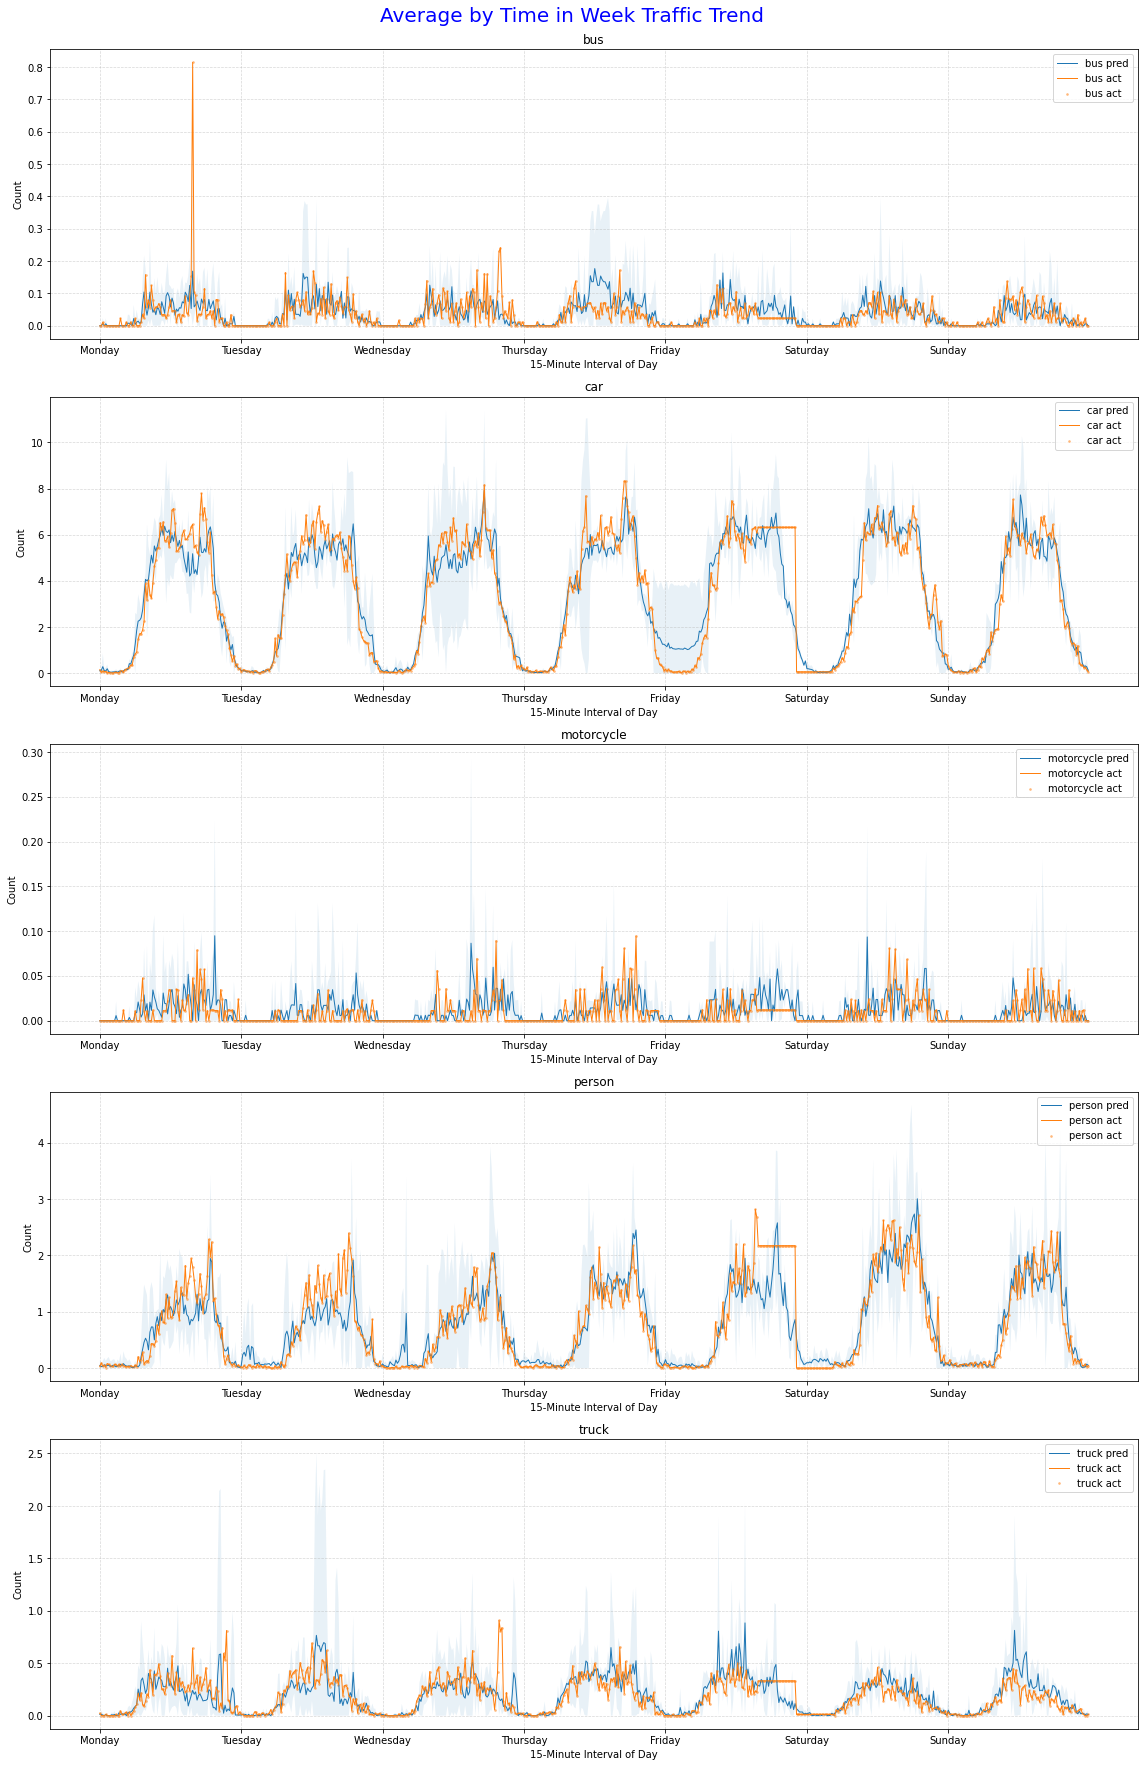

In [26]:
fig, subplot = plt.subplots(nrows=len(model_config.categories), ncols=1, figsize=(16,25))
fig.suptitle("Average by Time in Week Traffic Trend\n", fontsize=20, c='b')

_pred_df = weekminavg_train_df
_test_df = weekminavg_test_df

for i, c in enumerate(_pred_df.index.get_level_values(1).unique()):
    _pr_df = _pred_df[_pred_df.index.isin([c], level=1)]
    _te_df = _test_df[_test_df.index.isin([c], level=1)]
    
    y_val_pred = _pr_df[('rate', 'mean')].values
    y_err_pred = _pr_df[('rate', 'std')].values * 1.97
    subplot[i].plot(_pr_df.index.get_level_values(0), y_val_pred, label=f"{c} pred", lw=1)
    subplot[i].fill_between(_pr_df.index.get_level_values(0), np.clip(y_val_pred - y_err_pred,a_min=0, a_max=None), y_val_pred + y_err_pred, alpha=0.1)
    
    subplot[i].scatter(_te_df.index.get_level_values(0), _te_df.rate['mean'], alpha=.4, label=f"{c} act", s=3)
    y_val_te = _te_df[('rate', 'mean')].values
    subplot[i].plot(_te_df.index.get_level_values(0), y_val_te, label=f"{c} act", lw=1)
    
    subplot[i].set_title(c)
    subplot[i].set_ylabel("Count")
    subplot[i].set_xlabel("15-Minute Interval of Day")
    tick_locations = range(0,24*7*60,24*60)
    subplot[i].set_xticks(tick_locations)
    subplot[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    subplot[i].grid(linestyle='--', alpha=.5, linewidth=.7)
    subplot[i].legend()
    
plt.tight_layout()
plt.show()

In [27]:
for i, c in enumerate(weekminavg_test_df.index.get_level_values(1).unique()):
    true = weekminavg_test_df[weekminavg_test_df.index.isin([c], level=1)]['rate']['mean'].values
    pred = weekminavg_train_df[weekminavg_train_df.index.isin([c], level=1)]['rate']['mean'].values
    print(f"{c:10} {round(r2_score(y_true=true, y_pred=pred), 3):>8}")

bus           0.154
car           0.898
motorcycle   -0.284
person        0.778
truck         0.326


<h1>Baseline Model Results</h1>

<b>Weekday Average</b> <br>
This is the worst performing model and is no surprise.  Here, we predict the observation rate based on the overall average of each day of the week.  This will take into account that some days are busier than others, but does not consider the time of day when making prdictions.

<b>Time of Day</b> <br>
Making predictions based on the time of the day yields better results.  Here, we consider the time of the day, but not the day of the week.

<b>Day and Time</b> <br>
Lastly, we use both the day of the week and the time of the day to make prdictions.  Both the R2 and MSE scores improve which makes sense and is expected.  We will consider this our baseline model.

<h1>Model Design</h1> <br>
To improve on the baseline, we need to consider the previous trend.  Doing so would reflect things like seasonality, weather or special events.  For example, if Monday is slow, we may be able to expect that Tuesday is slow or if things are slow at 9am, they may also be slow at 3pm.  This will not take holidays into effect, so we may want to add holidays to the source data.

Our final objective is to predict the next day's traffic pattern at the end of each day.

<b>Step 1: Predict the next 15min rate.</b> <br>
- Use previous observations to record the next 15 minute interval as a single point.

<b>Step 2: Predict the next hour in 15min increments</b> <br>
- Predict several points in the future.

<b>Step 3: Explore other models</b> <br>
- Remove the poorest performing models from the mix.  Identify other models that may make up for shortcomings of selected models.

<b>Step 4: Finalize Models</b> <br>
- Determine best final model or combination of models to use as the final design.


<b>Step 5: Build prediction programs and incorporate into final product</b> <br>
- Revise the charting service in the monitor application to reflect preductions.
- Include the current accuracy of the model and update it dynamically.
- Build aplication so that at the end of each day, the models are refit with the new model data and predictions for the next day are built and charted.


<h2>Model Evaluation</h2>
First, we evaluate models trained with each individual classs name, one at a time.
These models will not take into account any correlation between rates from different objects that are detected.

In [28]:
model_config = ModelDataConfig(monitor_name='MyMonitor',
                               interval=60,
                               hours_in_training=24,
                               hours_in_prediction=24,
                               source_data_from_date="2020-09-27",
                               categories=['truck', 'bus', 'car', 'motorcycle', 'person'])

In [29]:
test_models = []
test_models.append(('LinReg', LinearRegression()))
# test_models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# test_models.append(('KNN', KNeighborsRegressor(n_neighbors=shifts))) 
test_models.append(('DecTree', DecisionTreeRegressor(max_depth= 10, random_state=0)))
test_models.append(('RF', RandomForestRegressor(n_jobs=-1, n_estimators = 150, random_state=0))) 
test_models.append(('GradientBoost', GradientBoostingRegressor(n_estimators = 150, random_state=0))) 
# test_models.append(('AdaBoost', AdaBoostRegressor(n_estimators = 150, random_state=0))) 
# test_models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
test_models.append(('LinearGAM', LinearGAM()))


In [30]:
def evaluate(m_config, _models):
        
    _tr_x, _tr_y, _te_x, _te_y = m_config.get_train_test_split()
       
    print(f"Train Cols: {[c for c in m_config.predictor_columns if not c.startswith('-')]}")
    
    for name, model in _models:
        if name == 'LinearGAM':
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-'):
                    if terms == None:
                        terms = s(i)
                    else:
                        terms += s(i)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            m = LinearGAM(terms=terms).fit(_tr_x, _tr_y)
            y_pred = np.clip(m.predict(_te_x), a_min=0, a_max=None)
            r2 = r2_score(y_true=_te_y,y_pred=y_pred)
            print(f"{name:15}: r2 mean-> {round(r2, 3):>6}")
        else:
            tscv = TimeSeriesSplit(n_splits=8)  
            cv_results = cross_val_score(model, _tr_x, _tr_y, cv=tscv, scoring='r2', n_jobs=-1)
            print(f"{name:15}: r2 mean-> {round(cv_results.mean(), 3):>6} std-> {round(cv_results.std(), 3):>6}")

In [31]:
# defulat 'class_code' indicator column
%time evaluate(model_config, test_models)

Train Cols: ['class_code']
LinReg         : r2 mean->  0.633 std->  0.608
DecTree        : r2 mean->  0.376 std->  0.446
RF             : r2 mean->  0.625 std->  0.354
GradientBoost  : r2 mean->  0.527 std->  0.572
LinearGAM      : r2 mean->  0.959
CPU times: user 1.57 s, sys: 237 ms, total: 1.81 s
Wall time: 6.24 s


In [32]:
model_config.set_predictor_columns(['class_code', 'weekday'])
%time evaluate(model_config, test_models)

Train Cols: ['class_code', 'weekday']
LinReg         : r2 mean->  0.415 std->  1.179
DecTree        : r2 mean->  0.343 std->  0.482
RF             : r2 mean->   0.62 std->  0.353
GradientBoost  : r2 mean->  0.516 std->  0.581
LinearGAM      : r2 mean->   0.96
CPU times: user 1.81 s, sys: 264 ms, total: 2.07 s
Wall time: 5.38 s


In [33]:
model_config.set_predictor_columns(['class_code', 'weekday', 'hour', 'minute'])
%time evaluate(model_config, test_models)

Train Cols: ['class_code', 'weekday', 'hour', 'minute']
LinReg         : r2 mean->  0.413 std->  1.187
DecTree        : r2 mean->  0.329 std->  0.513
RF             : r2 mean->  0.624 std->  0.351
GradientBoost  : r2 mean->  0.556 std->  0.502
LinearGAM      : r2 mean->  0.961
CPU times: user 1.76 s, sys: 221 ms, total: 1.98 s
Wall time: 6.09 s


In [34]:
# set the best performing combination of predictors
model_config.set_predictor_columns(['class_code', 'weekday', 'hour', 'minute'])

<h3>Quick Evaluation Results</h3>
Our best performers are the RandomForest, Gradient Descent and Linear GAM models.  The RandomForest and Gradient Descent scores are notably low as a result of how scikit scores models evaluated using cross validation and the fact that we are using a TimeSeries split of folds for the cross validation.  When weook closer at these models, we can expect to see higher   For now, we just want to do a quick validation to see models may perform best afater we do some model prapmeter fine-tuning.

<h3>Fine-Tuning</h3>
Let's fine-tune the best performers: RandomForest, GadientBoost, LinearGAM

In [35]:
def execute_grid_search(m_config, model, param_search) -> dict:
    results = {}
    
    _tr_x, _tr_y, _te_x, _te_y = m_config.get_train_test_split()
        
    # LinerGAM is not a ascikit model and will be handled separately.
    # The only pramter we use here is the lam (aka - smoother)
    if model.__class__.__name__ == "LinearGAM":
        best_score = 0
        for lam in param_search.get('lam'):
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-') or c.startswith('+'):
                    if terms == None:
                        terms = s(i, lam=lam)
                    else:
                        terms += s(i, lam=lam)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            _m = LinearGAM(terms=terms)
            y_pred = np.clip(_m.fit(_tr_x, _tr_y).predict(_te_x), a_min=0, a_max=None)
            _score = r2_score(y_true=_te_y,y_pred=y_pred)
            if _score > best_score:
                best_score = _score
                best_lam = lam
                best_model = _m
            print(f"lam: {lam:5}  r2: {_score}")
        
        best_params = f"\tlam: {best_lam}"
        
    else:
        tscv = TimeSeriesSplit(n_splits=8)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2', verbose=0, n_jobs=-1)
        gsearch.fit(_tr_x, _tr_y)
        best_model = gsearch.best_estimator_
        y_pred = np.clip(best_model.predict(_te_x), a_min=0, a_max=None)
        best_score = r2_score(y_true=_te_y, y_pred=y_pred)
        best_params = f"\t{' | '.join([f'{p}: {str(getattr(best_model, p))}' for p in param_search])}"

    print()
    print(model.__class__.__name__)
    print(f"Train Cols: {[c for c in _tr_x.columns if not (c.startswith('-'))]}")
    print(f"\tBest Model's R2 Score: {round(best_score, 4)}")
    print(f"\tBest Parameters: {best_params}")
    print(f"\tScore By Class:")
    for class_name in m_config.categories:
        idxs = _te_x[_te_x.class_code == m_config.get_code(class_name)].index
        r2 = r2_score(y_true=_te_y[idxs], y_pred=y_pred[idxs])
        print(f"\t\t{class_name:10}: {round(r2, 4):>6}")
        results.update({class_name: r2})
        
    results.update({'best_model': best_model})
    results.update({'best_overall_score': best_score})
    
    return {model.__class__.__name__: results}

<h3>Conclusion</h3>
After picking our best 3 overall performers and evaluating them for predicting each class, we observe that the parametrice models perform better despit an overall lower score than the LinearGAM.  Of the non-parametric models, the GradientBooster has a slight advantage over the RandomForestRegressor.

Based on pure numerical results, the GradientBooster is the best, but since we see varying results, I consider the comparisons inconclusice and will choose to visualize all models before drawing a final conclusion.

<h3>Visualize Model Predictions</h3>
These models only predict the next minute interval values. This is not very useful.  We will string predictions together to create the prediction for an entire day.

In [36]:
def get_best_model(m_config):
    models_to_evaluate = []

    models_to_evaluate.append({'model': LinearGAM(),
                               'param_search': { 
                                               #'lam': [500, 725, 750, 775, 800, 825, 850, 875, 1000],
                                                'lam': [.1, 10, 50, 100, 400, 800, 1200, 1600, 2000, 2500],
                                               }
                              })

#     models_to_evaluate.append( {'model': RandomForestRegressor(n_jobs=-1, random_state=0),
#                                 'param_search': { 
#                                                  'n_estimators': [10, 50, 100, 150],
#                                                  'max_features': ['auto'], #, 'sqrt', 'log2'], -> the best scores are always auto
#                                                  'max_depth' : [i for i in range(5,15)]
#                                                 }
#                                })

#     models_to_evaluate.append( {'model': GradientBoostingRegressor(random_state=0),
#                                 'param_search': { 
#                                                  'n_estimators': [20, 50, 100],
#                                                  'learning_rate' : [.05, .1, .5, 1],
#                                                  'loss' : ['ls', 'lad', 'huber', 'quantile']
#                                                 }
#                                })

    evaluation_results = {}
    for m in models_to_evaluate:
        r = execute_grid_search(m_config, m.get('model'), m.get('param_search'))
        evaluation_results.update(r)

    results_df = pd.DataFrame(evaluation_results).T
    return results_df[results_df.best_overall_score == results_df.best_overall_score.max()]['best_model'][0]


In [37]:
def string_predictions(m_config: ModelDataConfig, trained_model, from_date=None):

    n_intervals = m_config.hours_in_training * int(60/m_config.interval)
    n_predictors = len([c for c in m_config.predictor_columns if not c.startswith('-')])

    X, time_zero = m_config.get_seed_observation(on_date=from_date)
    
    # String predictions
    for i in range(1, n_intervals+1):
        r = list(range(n_predictors)) + list(range(len(X.columns)-n_intervals, len(X.columns)))
        X[f"+{i}"] = np.clip(trained_model.predict(X.iloc[:, r]), a_min=0, a_max=None)

    # Get initial DF with prediction columns
    r = list(range(n_predictors)) + list(range(len(X.columns) - n_intervals, len(X.columns)))
    X = X.iloc[:, r]
    
    # insert the class name
    idx = int(np.where(X.columns == 'class_code')[0][0])
    X.insert(idx+1, 'class_name', X['class_code'].apply(lambda s: m_config.get_category(s)))
    
    # rename future period columns to timestamp values
    time_stamps = [time_zero + pd.Timedelta(f'{m_config.interval * i} minutes') for i in range(1, n_intervals+1)]
    col_mapper = {old_c:time_stamps[int(old_c)-1] for old_c in X.columns if old_c.startswith('+')}
    
    id_vars = [c for c in X.columns if not c.startswith('+')]
    
    X.rename(columns=col_mapper, inplace=True)
    
    X = pd.melt(X, id_vars=id_vars, var_name='time_stamp', value_name='rate')
    
    X = m_config._add_time_features(X)
    
    return X

In [38]:
def plot_preds(m_config, trained_model, test_mode=True):

    if test_mode:
        from_date = m_config.test_df.time_stamp.min().isoformat()
    else:
        from_date = m_config.test_df.time_stamp.max().isoformat()
    
    pred_df = string_predictions(m_config=m_config,
                                 trained_model=trained_model, 
                                 from_date=from_date)
    
    fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
    fig.suptitle(f"Best Model Actual vs. Prediction \n {trained_model.__class__.__name__}", fontsize=20, c='b')

    cmap = plt.get_cmap('Dark2')
    N = len(m_config.categories)
    for i, c in enumerate(m_config.categories):
        _act_df = m_config.test_df[m_config.test_df.class_name == c]
        _pred_df = pred_df[pred_df.class_name == c]
        color = cmap(float(i)/N)
        subplot.scatter(_act_df.time_stamp, _act_df.rate, alpha=.5, color=color)
        subplot.plot(_act_df.time_stamp, _act_df.rate, label=f"{c} actual", lw=1, ls='--', alpha=.5, c=color)
        subplot.plot(_pred_df.time_stamp, _pred_df.rate, label=f"{c} pred", lw=2, c=color)
        subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
        subplot.legend()

    plt.show()


lam:   0.1  r2: 0.9589092621732935
lam:    10  r2: 0.9665345591464324
lam:    50  r2: 0.969904863533102
lam:   100  r2: 0.9712207431045244
lam:   400  r2: 0.9730096404983144
lam:   800  r2: 0.9735854265999797
lam:  1200  r2: 0.9738837337017403
lam:  1600  r2: 0.9740873802206115
lam:  2000  r2: 0.9742427061883601
lam:  2500  r2: 0.9743965072815831

LinearGAM
Train Cols: ['class_code', 'weekday', 'hour', 'minute']
	Best Model's R2 Score: 0.9744
	Best Parameters: 	lam: 2500
	Score By Class:
		truck     : 0.7218
		bus       : -1.3202
		car       : 0.9473
		motorcycle: -7.2894
		person    : 0.9487


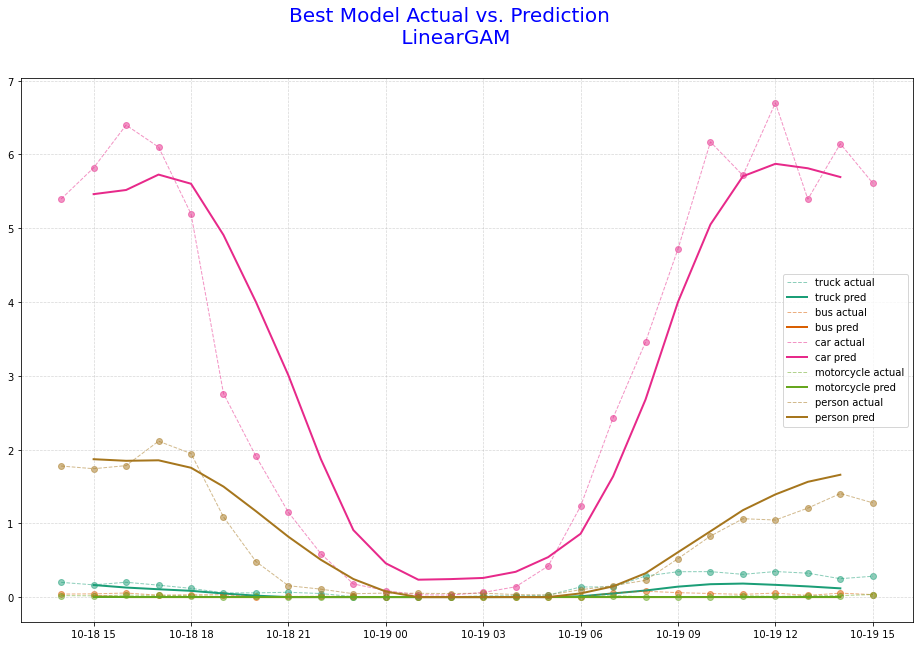

In [39]:
plot_preds(model_config, get_best_model(model_config), test_mode=True)

<h3>Result</h3>
Since the models only predict the next 15 minute increment, we use a stringing process to build a day's predictions by creating successive predictions.  After reviewing several different time periods, the LinearGAM performed the most consistely well.  Although, the RandomForest and GradientDescent models also did well, they can yield unreasonable results during periods of low(RF) or high(GD) activity.

We will choose the LinearGAM as the preferred model for this data set.

In [40]:
def create_forecast(monitor_name, interval, hours_in_training, hours_in_prediction, 
                    source_data_from_date:str=None, categories=None):

    m_config = ModelDataConfig(monitor_name=monitor_name,
                               interval=interval,
                               hours_in_training=hours_in_training,
                               hours_in_prediction=hours_in_prediction,
                               source_data_from_date=source_data_from_date)
    
    pred_df = string_predictions(m_config=m_config,
                                 trained_model=get_best_model(m_config),
                                 from_date=None)
    
    pred_df = pred_df[pred_df.class_name.isin(categories)][['time_stamp', 'class_name', 'rate']]

    return pred_df.to_dict(orient='list')

In [41]:
fc_dict = create_forecast(monitor_name='MyMonitor',
                          interval=60, 
                          hours_in_training=24, hours_in_prediction=24,
                          source_data_from_date="2020-09-27",
                          categories=['car', 'truck'])


lam:   0.1  r2: 0.9488345067566172
lam:    10  r2: 0.956496309745564
lam:    50  r2: 0.9607366932517746
lam:   100  r2: 0.9627156490424509
lam:   400  r2: 0.9656181057253146
lam:   800  r2: 0.9665136601176361
lam:  1200  r2: 0.9669627212676967
lam:  1600  r2: 0.9672679315215925
lam:  2000  r2: 0.9675028795146691
lam:  2500  r2: 0.9677391351265436

LinearGAM
Train Cols: ['class_code']
	Best Model's R2 Score: 0.9677
	Best Parameters: 	lam: 2500
	Score By Class:
		car       : 0.9439
		truck     : 0.8857


In [42]:
pd.DataFrame(fc_dict)

,class_code,class_name,time_stamp,rate,year,month,day,weekday,hour,minute,day_minute,week_minute
0,0,car,2020-10-19 16:00:00,5.929519,2020,10,19,0,16,0,960,960
1,1,truck,2020-10-19 16:00:00,0.243955,2020,10,19,0,16,0,960,960
2,0,car,2020-10-19 17:00:00,5.814099,2020,10,19,0,17,0,1020,1020
3,1,truck,2020-10-19 17:00:00,0.196961,2020,10,19,0,17,0,1020,1020
4,0,car,2020-10-19 18:00:00,5.099854,2020,10,19,0,18,0,1080,1080
5,1,truck,2020-10-19 18:00:00,0.155287,2020,10,19,0,18,0,1080,1080
6,0,car,2020-10-19 19:00:00,3.897891,2020,10,19,0,19,0,1140,1140
7,1,truck,2020-10-19 19:00:00,0.125308,2020,10,19,0,19,0,1140,1140
8,0,car,2020-10-19 20:00:00,2.636039,2020,10,19,0,20,0,1200,1200
9,1,truck,2020-10-19 20:00:00,0.094631,2020,10,19,0,20,0,1200,1200
